## Importing Libraries:
Simply importing all necessary libraries here

In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from time import time
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import joblib, json


import matplotlib.pyplot as plt

## Loading Dataset
Simply loading the dataset and printing the first few rows

In [ ]:
# reading the csv
data = pd.read_csv("application_train.csv")

# printing the first few rows (at the top)
data.head()

In [ ]:
# checking whether there are any missing values inside the data
data.isnull().sum()

## Identifying numeric vs. categorical columns
Simply figuring which column is numeric and which is categorical

In [ ]:
# seperating the categorical columns and numerical columns
cat_cols = [c for c in data.columns if data[c].dtype == "object"]
num_cols = [c for c in data.columns if data[c].dtype != "object"]

print(f"Categorical: {len(cat_cols)} columns")
print(f"Numerical  : {len(num_cols)} columns")

## Fixing known anomalies & basic clean‑ups
After doing some research on the dataset, we figured out some known anomalies so tackling them here

In [ ]:
data['DAYS_EMPLOYED_ANOM'] = (data['DAYS_EMPLOYED'] == 365243).astype(int)
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# also turning DAYS_BIRTH into positive age in years for interpretability . . .
data['AGE_YEARS'] = (-data['DAYS_BIRTH']) // 365

## Handling missing values
Simply using effective ways to handle the missing values

In [ ]:
# Using median for numeric → robust to outliers
num_imputer = SimpleImputer(strategy="median")
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# and using Most‑frequent for categorical → keeps real category names
cat_imputer = SimpleImputer(strategy="most_frequent")
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

## Encode categorical features
Simply encoding the categorical columns here

In [ ]:
# firstly Label‑encoding binary categories -> exactly 2 unique values
binary_cols = [c for c in cat_cols if data[c].nunique() == 2]
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# and now One‑hot encoding the rest, dropping first dummy to dodge multicollinearity
multi_cat_cols = [c for c in cat_cols if c not in binary_cols]
data = pd.get_dummies(data, columns=multi_cat_cols, drop_first=True)

print("Data shape after encoding:", data.shape) 

## Verification & Tidying it up
Simple final testing and techniques to save RAM

In [ ]:
# downcasting ints/floats where possible to save RAM
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = pd.to_numeric(data[col], downcast='float')
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = pd.to_numeric(data[col], downcast='integer')

print(data.info(memory_usage='deep'))

In [ ]:
data.isnull().sum()[data.isnull().sum() > 0] # confirms handling of NAN

## Saving the cleaned dataframe
Simply saving the cleaned up dataframe which we will now use for modeling

In [ ]:
data.to_csv("application_train_cleaned.csv", index=False)
print("Clean file written to application_train_cleaned.csv")

## Loading the cleaned dataframe
Simply loading the cleaned up dataframe

In [2]:
df = pd.read_csv("application_train_cleaned.csv")
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002.0,1.0,0,0,1,0.0,202500.0,406597.5,24700.5,351000.0,...,1,0,0,0,0,0,0,0,1,0
1,100003.0,0.0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,0,0,0,0,0,0,0
2,100004.0,0.0,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,1,0,0,0,0,0,0,1,0,0
3,100006.0,0.0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,1,0,0,0,0,0,0,1,0,0
4,100007.0,0.0,0,0,1,0.0,121500.0,513000.0,21865.5,513000.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0,0,0,0.0,157500.0,254700.0,27558.0,225000.0,...,1,0,0,0,0,0,0,0,1,0
307507,456252.0,0.0,0,0,1,0.0,72000.0,269550.0,12001.5,225000.0,...,1,0,0,0,0,0,0,0,1,0
307508,456253.0,0.0,0,0,1,0.0,153000.0,677664.0,29979.0,585000.0,...,1,0,0,0,0,0,0,1,0,0
307509,456254.0,1.0,0,0,1,0.0,171000.0,370107.0,20205.0,319500.0,...,1,0,0,0,0,0,0,0,1,0


## Domain‑ratio features
We did thorough research and used multiple sources to understand the data, and now worked on feature engineering

In [3]:
df['CREDIT_INCOME_RATIO']   = df['AMT_CREDIT']  / (df['AMT_INCOME_TOTAL'] + 1)
df['ANNUITY_INCOME_RATIO']  = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)
df['ANNUITY_CREDIT_RATIO']  = df['AMT_ANNUITY'] / (df['AMT_CREDIT'] + 1)
df['GOODS_CREDIT_RATIO']    = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1)
df['INCOME_PER_PERSON']     = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)
df['CHILDREN_RATIO']        = df['CNT_CHILDREN'] / (df['CNT_FAM_MEMBERS'] + 1)
df['EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['EMPLOY_TO_AGE_RATIO']   = df['DAYS_EMPLOYED'] / (df['AGE_YEARS'] * 365)  # AGE_YEARS came from earlier cell

## Clipping extreme outliers
Simply handling outliers

In [4]:
# winsorize numeric columns to blunt crazy tails . . .
num_features = df.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns
low_q, hi_q = 0.01, 0.99

for col in num_features:
    lo = df[col].quantile(low_q)
    hi = df[col].quantile(hi_q)
    df[col] = df[col].clip(lo, hi)

In [5]:
# for heavy skews we are using log1p

# making log1p versions only for positive, highly‑skewed features
skew_thresh = 1.0
for col in num_features:
    if df[col].min() >= 0 and abs(skew(df[col])) > skew_thresh:
        df[col + '_LOG1P'] = np.log1p(df[col])

C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_LOG1P'] = np.log1p(df[col])
C:\Users\HP\AppData\Local\Temp\ipykernel_19244\772406296.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [6]:
# now data is ready for modeling
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FONDKAPREMONT_MODE_org spec account_LOG1P,FONDKAPREMONT_MODE_reg oper account_LOG1P,FONDKAPREMONT_MODE_reg oper spec account_LOG1P,"WALLSMATERIAL_MODE_Stone, brick_LOG1P",WALLSMATERIAL_MODE_Wooden_LOG1P,CREDIT_INCOME_RATIO_LOG1P,ANNUITY_CREDIT_RATIO_LOG1P,INCOME_PER_PERSON_LOG1P,CHILDREN_RATIO_LOG1P,EMPLOY_TO_BIRTH_RATIO_LOG1P
0,103590.2,1.0,0,0,1,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.693147,0.0,0.693147,0.0,1.101235,0.058975,11.525358,0.0,0.065159
1,103590.2,0.0,0,0,0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.693147,0.0,0.000000,0.0,1.756259,0.027224,11.407576,0.0,0.068464
2,103590.2,0.0,1,1,1,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.693147,0.0,0.000000,0.0,1.098602,0.048790,10.426765,0.0,0.011744
3,103590.2,0.0,0,0,1,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.693147,0.0,0.000000,0.0,1.198804,0.090701,10.714440,0.0,0.148338
4,103590.2,0.0,0,0,1,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.693147,0.0,0.000000,0.0,1.652916,0.041739,11.014539,0.0,0.141863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,452712.9,0.0,0,0,0,0.0,157500.0,254700.0,27558.0,225000.0,...,0.0,0.693147,0.0,0.693147,0.0,0.962079,0.102735,11.274046,0.0,0.024988
307507,452712.9,0.0,0,0,1,0.0,72000.0,269550.0,12001.5,225000.0,...,0.0,0.693147,0.0,0.693147,0.0,1.556817,0.043561,10.491302,0.0,0.076337
307508,452712.9,0.0,0,0,1,0.0,153000.0,677664.0,29979.0,585000.0,...,0.0,0.693147,0.0,0.000000,0.0,1.691782,0.043288,11.245059,0.0,0.424788
307509,452712.9,1.0,0,0,1,0.0,171000.0,370107.0,20205.0,319500.0,...,0.0,0.693147,0.0,0.693147,0.0,1.151949,0.053154,10.950824,0.0,0.336568


In [7]:
# sanity check
print("Any NaNs left?", df.isna().sum().sum()) 
print("Data shape:", df.shape)

Any NaNs left? 0
Data shape: (307511, 364)


## Model Training:
Simply using 'df' now for model training - DT Classifier

In [8]:
# removing any column that contains TARGET except the real target
leak_cols = [c for c in df.columns if ('TARGET' in c and c != 'TARGET')]
print("Leaky columns:", leak_cols)

df = df.drop(columns=leak_cols)

Leaky columns: ['TARGET_LOG1P']


In [9]:
feature_cols = [c for c in df.columns if c not in ['TARGET', 'SK_ID_CURR']]
X = df[feature_cols]
y = df['TARGET']

# 10% test, then 20% of remaining as validation (72/18/10 split)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("Class ratio (train):\n", y_train.value_counts(normalize=True))

Train: (221407, 361)  Val: (55352, 361)  Test: (30752, 361)
Class ratio (train):
 0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64


## Decision Tree + GridSearchCV (ROC‑AUC scoring)
Implementing DT Classifier + Working on gridsearch CV below

In [10]:
# defining the grid
param_grid = {
    'max_depth': [4, 6, 8],                
    'min_samples_split': [100, 200],
    'min_samples_leaf': [50, 100],
    'max_features': [None, 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 1e-4]               
}

# Sample 30% of training data for the search
sample_frac = 0.30
sample_idx = y_train.sample(frac=sample_frac, random_state=42).index
X_search = X_train.loc[sample_idx]
y_search = y_train.loc[sample_idx]

# 3-fold CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# this is for debugging
n_candidates = len(list(ParameterGrid(param_grid)))
total_fits = n_candidates * cv.get_n_splits()
print(f"Grid size: {n_candidates} params × {cv.get_n_splits()} folds = {total_fits} fits")
print(f"Search sample: {X_search.shape[0]} rows ({sample_frac*100:.0f}%)")

# simply running GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
start = time()
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=0  #
)
grid.fit(X_search, y_search)
elapsed = (time() - start) / 60
print(f"GridSearch done in {elapsed:.2f} min")

best_params = grid.best_params_
best_score  = grid.best_score_
print("Best CV ROC-AUC (sample):", round(best_score, 4))
print("Best params:", best_params)

# now refitting the best model on full training data
best_dt = DecisionTreeClassifier(random_state=42, **best_params)
best_dt.fit(X_train, y_train)

Grid size: 192 params × 3 folds = 576 fits
Search sample: 66422 rows (30%)
GridSearch done in 2.02 min
Best CV ROC-AUC (sample): 0.7029
Best params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 50, 'min_samples_split': 200}


DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, min_samples_split=200,
                       random_state=42)

##  Validating the best model
Simply doing validation here

In [11]:
y_val_proba = best_dt.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_proba)
print("Validation ROC AUC:", val_auc)

# baseline threshold = 0.5. . .
y_val_pred = (y_val_proba >= 0.5).astype(int)
print("Classification Report (thr=0.5):\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation ROC AUC: 0.7085388544499234
Classification Report (thr=0.5):
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     50884
         1.0       0.49      0.01      0.01      4468

    accuracy                           0.92     55352
   macro avg       0.71      0.50      0.49     55352
weighted avg       0.89      0.92      0.88     55352

Confusion Matrix:
 [[50853    31]
 [ 4438    30]]


In [16]:
# simply finding the better threshold

prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = f1.argmax()
best_thr = thr[best_idx]

print(f"Best F1: {f1[best_idx]:.3f} at threshold={best_thr:.3f}")

y_val_pred_opt = (y_val_proba >= best_thr).astype(int)
print("Classification Report (opt threshold):\n",
      classification_report(y_val, y_val_pred_opt))

Best F1: 0.262 at threshold=0.138
Classification Report (opt threshold):
               precision    recall  f1-score   support

         0.0       0.94      0.87      0.91     50884
         1.0       0.20      0.37      0.26      4468

    accuracy                           0.83     55352
   macro avg       0.57      0.62      0.58     55352
weighted avg       0.88      0.83      0.85     55352



## Confusion Matrix & ROC Curve
simply plotting ROC Curve along with confusion matrix

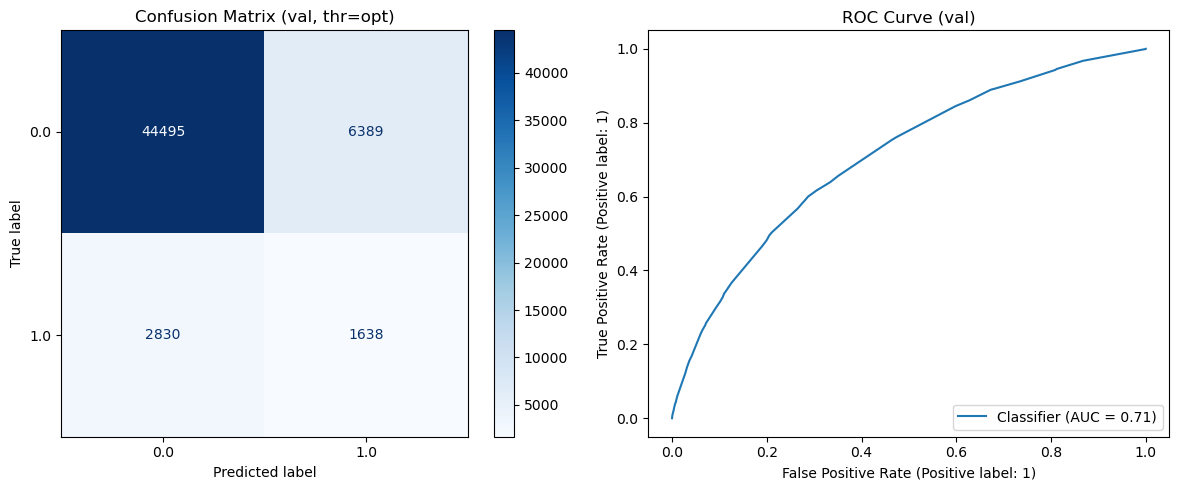

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_opt, ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix (val, thr=opt)")

RocCurveDisplay.from_predictions(y_val, y_val_proba, ax=ax[1])
ax[1].set_title("ROC Curve (val)")
plt.tight_layout()
plt.show()

## Determining Important Features
Listing top 25 important features

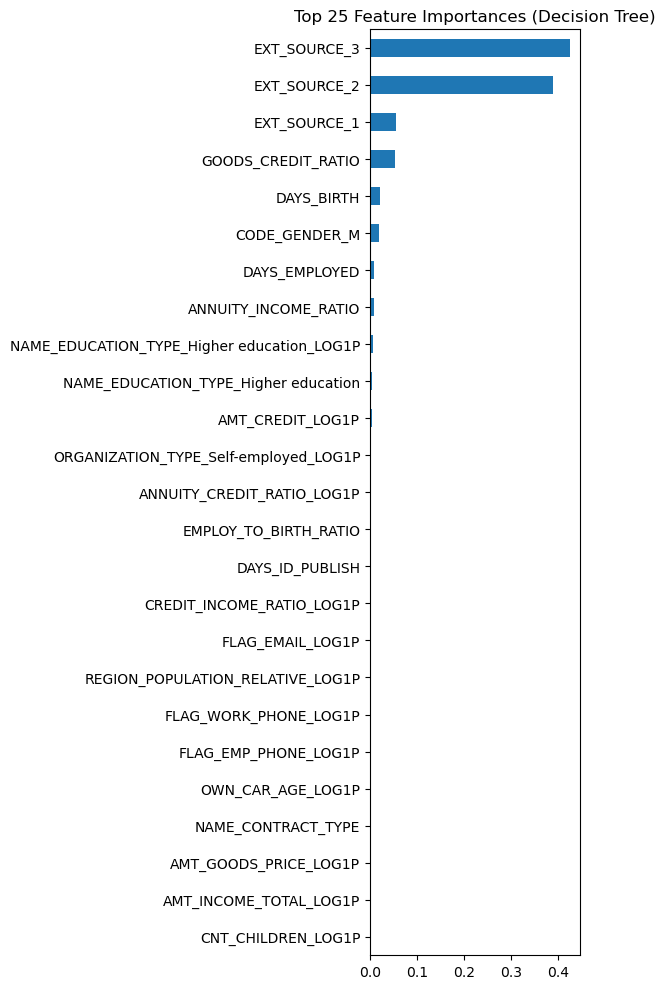

In [18]:
fi = pd.Series(best_dt.feature_importances_, index=X_train.columns)
top_fi = fi.sort_values(ascending=False).head(25)

plt.figure(figsize=(6,10))
top_fi[::-1].plot(kind='barh')
plt.title("Top 25 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

## Comparing with RandomForest
Now we are comparing our model with RF and checking if any improvements occur

In [19]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_val_proba_rf = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_val_proba_rf)
print("RandomForest Val AUC:", rf_auc)

RandomForest Val AUC: 0.7478016202633236


## Final test set evaluation & saving everything
Simply doing some final tests and saving everything (pkl)

In [20]:
# using the threshold we picked
y_test_proba = best_dt.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)
y_test_pred = (y_test_proba >= best_thr).astype(int)

print("Test ROC AUC:", test_auc)
print("Classification Report (test):\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix (test):\n", confusion_matrix(y_test, y_test_pred))

# saving
joblib.dump(best_dt, "best_decision_tree.pkl")
np.save("optimal_threshold.npy", best_thr)
print("saved model & threshold.")

Test ROC AUC: 0.7114111855057064
Classification Report (test):
               precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     28269
         1.0       0.21      0.37      0.27      2483

    accuracy                           0.84     30752
   macro avg       0.57      0.62      0.59     30752
weighted avg       0.88      0.84      0.86     30752

Confusion Matrix (test):
 [[24788  3481]
 [ 1566   917]]
saved model & threshold.


In [25]:
# saving the columns . . .
feature_cols = X.columns.tolist()
json.dump(feature_cols, open("feature_cols.json", "w"))

fill_values = X_train.median()
fill_values.to_json("feature_medians.json")

In [26]:
fi = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
fi.head(15)

EXT_SOURCE_3                                  0.426069
EXT_SOURCE_2                                  0.388994
EXT_SOURCE_1                                  0.054935
GOODS_CREDIT_RATIO                            0.052098
DAYS_BIRTH                                    0.021440
CODE_GENDER_M                                 0.018636
DAYS_EMPLOYED                                 0.007892
ANNUITY_INCOME_RATIO                          0.007498
NAME_EDUCATION_TYPE_Higher education_LOG1P    0.006004
NAME_EDUCATION_TYPE_Higher education          0.004375
AMT_CREDIT_LOG1P                              0.003442
ORGANIZATION_TYPE_Self-employed_LOG1P         0.002291
ANNUITY_CREDIT_RATIO_LOG1P                    0.002117
EMPLOY_TO_BIRTH_RATIO                         0.001710
DAYS_ID_PUBLISH                               0.001568
dtype: float64